<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/BaseCASE_Grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.6 MB/s eta 0:00:00


In [5]:
pip install cartopy

In [3]:
pip install folium

# $O_{3}$

In [65]:
import pandas as pd
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree
import netCDF4

# Φόρτωση των δεδομένων από το CSV αρχείο (σταθμοί)
stations = pd.read_csv("yearly_SURF_ppb_O3.csv")

# Εξαγωγή συντεταγμένων σταθμών
station_lons = stations["lon"].values
station_lats = stations["lat"].values

# Φόρτωση δεδομένων NetCDF (μοντέλο)
nc_data = xr.open_dataset("BaseCase_PERT_O3_YEARLY.nc")

# Εξαγωγή συντεταγμένων και συγκεντρώσεων O₃ από το NetCDF
nc_lons = nc_data["lon"].values  # Συντεταγμένες longitude πλέγματος
nc_lats = nc_data["lat"].values  # Συντεταγμένες latitude πλέγματος
nc_ozone = nc_data["SURF_ppb_O3"].values  # Συγκεντρώσεις O₃ (π.χ., [lat, lon])

# Δημιουργία πλέγματος συντεταγμένων για τα κέντρα των κελιών
lon_grid, lat_grid = np.meshgrid(nc_lons, nc_lats)

# Δημιουργία KDTree για τα κέντρα των κελιών του πλέγματος
grid_points = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
kdtree = cKDTree(grid_points)

# Υπολογισμός των πλησιέστερων κελιών για κάθε σταθμό (βάσει συντεταγμένων)
station_points = np.column_stack([station_lons, station_lats])
distances, indices = kdtree.query(station_points)

# Λήψη των συντεταγμένων και τιμών O₃ από τα πλησιέστερα κελιά
matched_lons = grid_points[indices, 0]  # Πλησιέστερο longitude
matched_lats = grid_points[indices, 1]  # Πλησιέστερο latitude
matched_ozone = nc_ozone.ravel()[indices]  # Τιμές O₃ από το NetCDF

# Προσθήκη των αποτελεσμάτων στο DataFrame των σταθμών
stations["nearest_grid_lon"] = matched_lons
stations["nearest_grid_lat"] = matched_lats
stations["nearest_SURF_ppb_O3"] = matched_ozone

# Δημιουργία της στήλης 'grid_cell_index' αν δεν υπάρχει ήδη
cell_indices = np.indices(lon_grid.shape)
cell_indices_flattened = np.stack(cell_indices, axis=-1).reshape(-1, 2)
stations["grid_cell_index"] = [tuple(cell_indices_flattened[i]) for i in indices]

# Αλλαγή της σειράς των στηλών όπως ζητήθηκε
stations = stations[['lon', 'lat', 'nearest_grid_lon', 'nearest_grid_lat', 'grid_cell_index', 'SURF_ppb_O3', 'nearest_SURF_ppb_O3']]

# Αποθήκευση του ενημερωμένου DataFrame σε νέο αρχείο CSV
stations.to_csv("baseO3nearest_grid.csv", index=False)

# Εμφάνιση των πρώτων γραμμών του ενημερωμένου DataFrame για έλεγχο
stations.head()

,lon,lat,nearest_grid_lon,nearest_grid_lat,grid_cell_index,SURF_ppb_O3,nearest_SURF_ppb_O3
0,13.1945,46.9350,13.15,46.925,"(289, 282)",42.744987,42.685699
1,13.9145,46.6954,13.95,46.675,"(284, 290)",35.835648,35.785275
2,14.4574,46.8666,14.45,46.875,"(288, 295)",37.613846,37.578777
3,16.0625,48.3294,16.05,48.325,"(317, 311)",31.038498,31.075140
4,16.3315,48.1247,16.35,48.125,"(313, 314)",28.654785,28.671650


In [7]:
print("Total stations:", len(stations))
print("Unique grid cells:", stations["grid_cell_index"].nunique())

Total stations: 3263
Unique grid cells: 3263


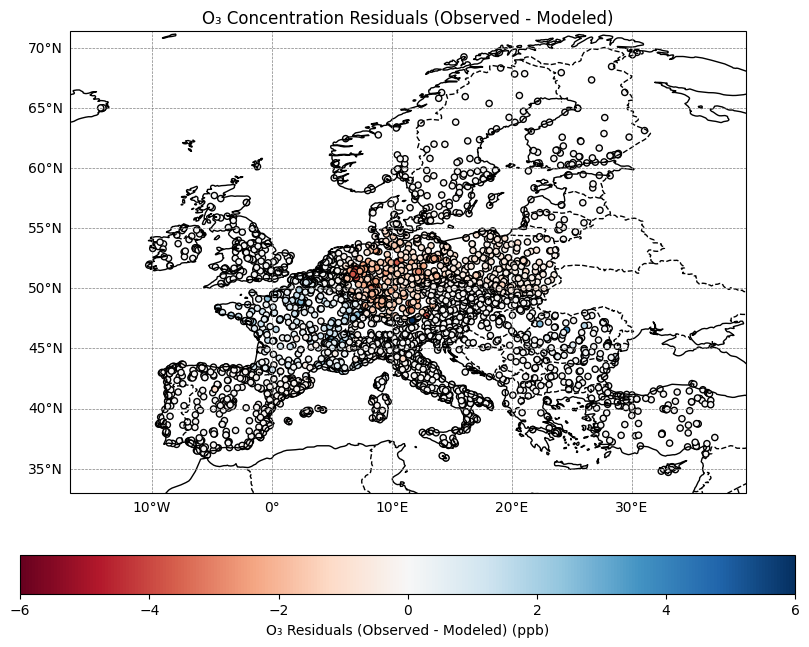

In [112]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseO3nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["O3_residuals"],
    cmap="RdBu",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="black",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("O₃ Residuals (Observed - Modeled) (ppb)")

# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


In [67]:
# Compute min and max of PM2.5 residuals
pm25_min = stations["O3_residuals"].min()
pm25_max = stations["O3_residuals"].max()

# Print the results
print("Minimum Ο3 Residual (Observed - Modeled):", pm25_min)
print("Maximum Ο3 Residual (Observed - Modeled):", pm25_max)

Minimum Ο3 Residual (Observed - Modeled): -5.8957921058349605
Maximum Ο3 Residual (Observed - Modeled): 9.078496495361328


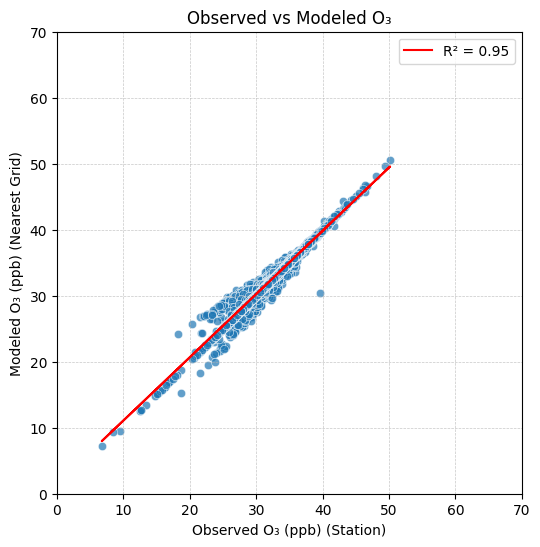

Mean Absolute Error (MAE): 0.48
Root Mean Squared Error (RMSE): 0.94


In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("baseO3nearest_grid.csv")

# Extract observed and modeled PM2.5 values
observed_O3 = stations["SURF_ppb_O3"]
modeled_O3 = stations["nearest_SURF_ppb_O3"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_O3, modeled_O3)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_O3, y=modeled_O3, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_O3, slope * observed_O3 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed O₃ (ppb) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled O₃ (ppb) (Nearest Grid)")
plt.title("Observed vs Modeled O₃")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_O3, modeled_O3)
rmse = np.sqrt(mean_squared_error(observed_O3, modeled_O3))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# $NO_{2}$

In [68]:
import pandas as pd
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree
import netCDF4

# Φόρτωση των δεδομένων από το CSV αρχείο (σταθμοί)
stations = pd.read_csv("yearly_SURF_ug_NO2.csv")

# Εξαγωγή συντεταγμένων σταθμών
station_lons = stations["lon"].values
station_lats = stations["lat"].values

# Φόρτωση δεδομένων NetCDF (μοντέλο)
nc_data = xr.open_dataset("BaseCase_PERT_NO2_YEARLY.nc")

# Εξαγωγή συντεταγμένων και συγκεντρώσεων O₃ από το NetCDF
nc_lons = nc_data["lon"].values  # Συντεταγμένες longitude πλέγματος
nc_lats = nc_data["lat"].values  # Συντεταγμένες latitude πλέγματος
nc_ozone = nc_data["SURF_ug_NO2"].values  # Συγκεντρώσεις O₃ (π.χ., [lat, lon])

# Δημιουργία πλέγματος συντεταγμένων για τα κέντρα των κελιών
lon_grid, lat_grid = np.meshgrid(nc_lons, nc_lats)

# Δημιουργία KDTree για τα κέντρα των κελιών του πλέγματος
grid_points = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
kdtree = cKDTree(grid_points)

# Υπολογισμός των πλησιέστερων κελιών για κάθε σταθμό (βάσει συντεταγμένων)
station_points = np.column_stack([station_lons, station_lats])
distances, indices = kdtree.query(station_points)

# Λήψη των συντεταγμένων και τιμών O₃ από τα πλησιέστερα κελιά
matched_lons = grid_points[indices, 0]  # Πλησιέστερο longitude
matched_lats = grid_points[indices, 1]  # Πλησιέστερο latitude
matched_ozone = nc_ozone.ravel()[indices]  # Τιμές O₃ από το NetCDF

# Προσθήκη των αποτελεσμάτων στο DataFrame των σταθμών
stations["nearest_grid_lon"] = matched_lons
stations["nearest_grid_lat"] = matched_lats
stations["nearest_SURF_ug_NO2"] = matched_ozone

# Δημιουργία της στήλης 'grid_cell_index' αν δεν υπάρχει ήδη
cell_indices = np.indices(lon_grid.shape)
cell_indices_flattened = np.stack(cell_indices, axis=-1).reshape(-1, 2)
stations["grid_cell_index"] = [tuple(cell_indices_flattened[i]) for i in indices]

# Αλλαγή της σειράς των στηλών όπως ζητήθηκε
stations = stations[['lon', 'lat', 'nearest_grid_lon', 'nearest_grid_lat', 'grid_cell_index', 'SURF_ug_NO2', 'nearest_SURF_ug_NO2']]

# Αποθήκευση του ενημερωμένου DataFrame σε νέο αρχείο CSV
stations.to_csv("baseNO2nearest_grid.csv", index=False)

# Εμφάνιση των πρώτων γραμμών του ενημερωμένου DataFrame για έλεγχο
stations.head()

,lon,lat,nearest_grid_lon,nearest_grid_lat,grid_cell_index,SURF_ug_NO2,nearest_SURF_ug_NO2
0,13.1945,46.9350,13.15,46.925,"(289, 282)",1.134969,1.089322
1,13.9145,46.6954,13.95,46.675,"(284, 290)",2.722058,2.686655
2,14.4574,46.8666,14.45,46.875,"(288, 295)",3.815312,3.766372
3,16.0625,48.3294,16.05,48.325,"(317, 311)",9.188441,9.036489
4,16.3315,48.1247,16.35,48.125,"(313, 314)",16.215141,16.105865


In [69]:
print("Total stations:", len(stations))
print("Unique grid cells:", stations["grid_cell_index"].nunique())

Total stations: 3263
Unique grid cells: 3263


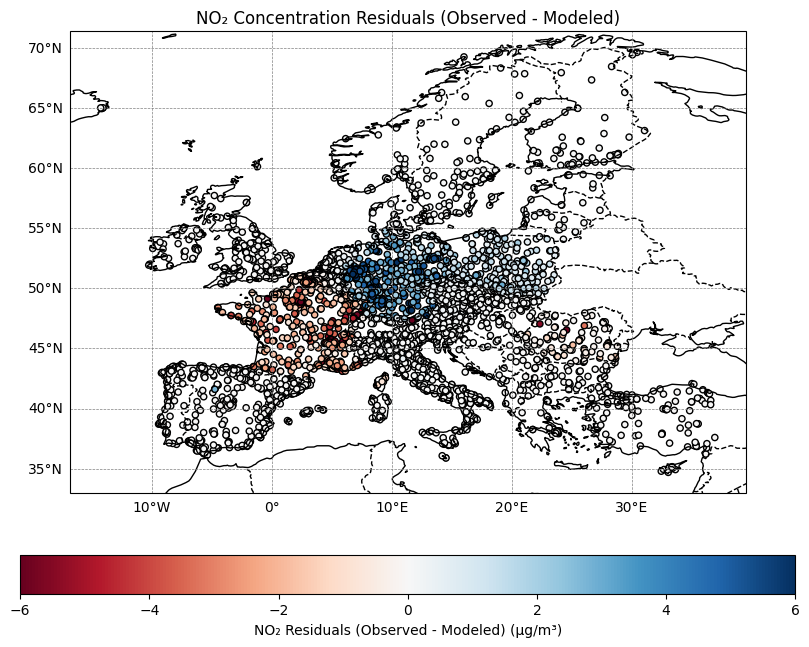

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseNO2nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["NO2_residuals"],
    cmap="RdBu",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="black",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("NO₂ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


In [71]:
import pandas as pd

# Load the dataset
stations = pd.read_csv("basePM25nearest_grid.csv")

# Compute min and max of PM2.5 residuals
pm25_min = stations["PM25_residuals"].min()
pm25_max = stations["PM25_residuals"].max()

# Print the results
print("Minimum PM2.5 Residual (Observed - Modeled):", pm25_min)
print("Maximum PM2.5 Residual (Observed - Modeled):", pm25_max)

Minimum PM2.5 Residual (Observed - Modeled): -2.636953353881836
Maximum PM2.5 Residual (Observed - Modeled): 15.435415267944336


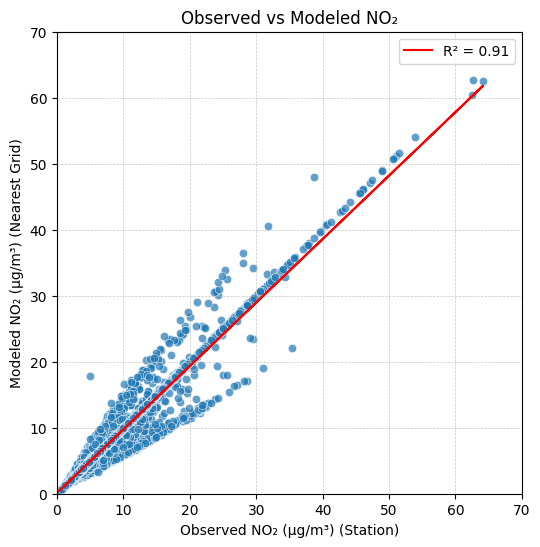

Mean Absolute Error (MAE): 1.10
Root Mean Squared Error (RMSE): 2.20


In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("baseNO2nearest_grid.csv")

# Extract observed and modeled PM2.5 values
observed_NO2 = stations["SURF_ug_NO2"]
modeled_NO2 = stations["nearest_SURF_ug_NO2"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_NO2, modeled_NO2)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_NO2, y=modeled_NO2, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_NO2, slope * observed_NO2 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed NO₂ (µg/m³) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled NO₂ (µg/m³) (Nearest Grid)")
plt.title("Observed vs Modeled NO₂")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_NO2, modeled_NO2)
rmse = np.sqrt(mean_squared_error(observed_NO2, modeled_NO2))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# $PM_{2.5}$

In [121]:
import pandas as pd
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree
import netCDF4

# Φόρτωση των δεδομένων από το CSV αρχείο (σταθμοί)
stations = pd.read_csv("yearly_SURF_ug_PM25_rh50.csv")

# Εξαγωγή συντεταγμένων σταθμών
station_lons = stations["lon"].values
station_lats = stations["lat"].values

# Φόρτωση δεδομένων NetCDF (μοντέλο)
nc_data = xr.open_dataset("BaseCase_PERT_PM25_rh50_YEARLY.nc")

# Εξαγωγή συντεταγμένων και συγκεντρώσεων O₃ από το NetCDF
nc_lons = nc_data["lon"].values  # Συντεταγμένες longitude πλέγματος
nc_lats = nc_data["lat"].values  # Συντεταγμένες latitude πλέγματος
nc_ozone = nc_data["SURF_ug_PM25_rh50"].values  # Συγκεντρώσεις O₃ (π.χ., [lat, lon])

# Δημιουργία πλέγματος συντεταγμένων για τα κέντρα των κελιών
lon_grid, lat_grid = np.meshgrid(nc_lons, nc_lats)

# Δημιουργία KDTree για τα κέντρα των κελιών του πλέγματος
grid_points = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
kdtree = cKDTree(grid_points)

# Υπολογισμός των πλησιέστερων κελιών για κάθε σταθμό (βάσει συντεταγμένων)
station_points = np.column_stack([station_lons, station_lats])
distances, indices = kdtree.query(station_points)

# Λήψη των συντεταγμένων και τιμών O₃ από τα πλησιέστερα κελιά
matched_lons = grid_points[indices, 0]  # Πλησιέστερο longitude
matched_lats = grid_points[indices, 1]  # Πλησιέστερο latitude
matched_ozone = nc_ozone.ravel()[indices]  # Τιμές O₃ από το NetCDF

# Προσθήκη των αποτελεσμάτων στο DataFrame των σταθμών
stations["nearest_grid_lon"] = matched_lons
stations["nearest_grid_lat"] = matched_lats
stations["nearest_SURF_ug_PM25_rh50"] = matched_ozone

# Δημιουργία της στήλης 'grid_cell_index' αν δεν υπάρχει ήδη
cell_indices = np.indices(lon_grid.shape)
cell_indices_flattened = np.stack(cell_indices, axis=-1).reshape(-1, 2)
stations["grid_cell_index"] = [tuple(cell_indices_flattened[i]) for i in indices]

# Αλλαγή της σειράς των στηλών όπως ζητήθηκε
stations = stations[['lon', 'lat', 'nearest_grid_lon', 'nearest_grid_lat', 'grid_cell_index', 'SURF_ug_PM25_rh50', 'nearest_SURF_ug_PM25_rh50']]

# Αποθήκευση του ενημερωμένου DataFrame σε νέο αρχείο CSV
stations.to_csv("basePM25nearest_grid.csv", index=False)

# Εμφάνιση των πρώτων γραμμών του ενημερωμένου DataFrame για έλεγχο
stations.head()

,lon,lat,nearest_grid_lon,nearest_grid_lat,grid_cell_index,SURF_ug_PM25_rh50,nearest_SURF_ug_PM25_rh50
0,13.1945,46.9350,13.15,46.925,"(289, 282)",3.370927,3.208787
1,13.9145,46.6954,13.95,46.675,"(284, 290)",6.053020,5.893659
2,14.4574,46.8666,14.45,46.875,"(288, 295)",5.833692,5.619750
3,16.0625,48.3294,16.05,48.325,"(317, 311)",9.499794,8.903049
4,16.3315,48.1247,16.35,48.125,"(313, 314)",10.630700,10.086845


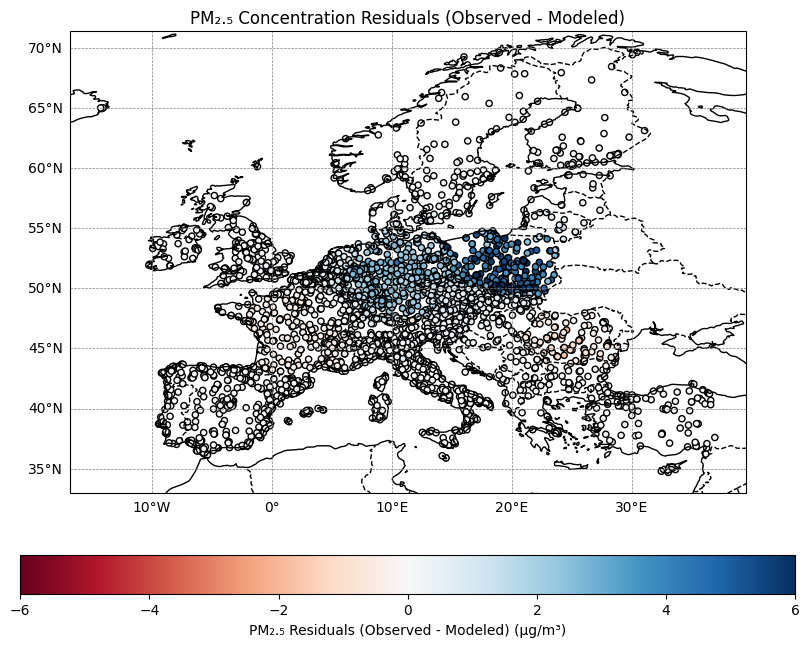

In [122]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("basePM25nearest_grid.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["PM25_residuals"],
    cmap="RdBu",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="black",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("PM₂.₅ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("PM₂.₅ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

In [123]:
import pandas as pd


# Compute min and max of PM2.5 residuals
pm25_min = stations["PM25_residuals"].min()
pm25_max = stations["PM25_residuals"].max()

# Print the results
print("Minimum PM2.5 Residual (Observed - Modeled):", pm25_min)
print("Maximum PM2.5 Residual (Observed - Modeled):", pm25_max)

Minimum PM2.5 Residual (Observed - Modeled): -2.6369533168945303
Maximum PM2.5 Residual (Observed - Modeled): 15.435415325439454


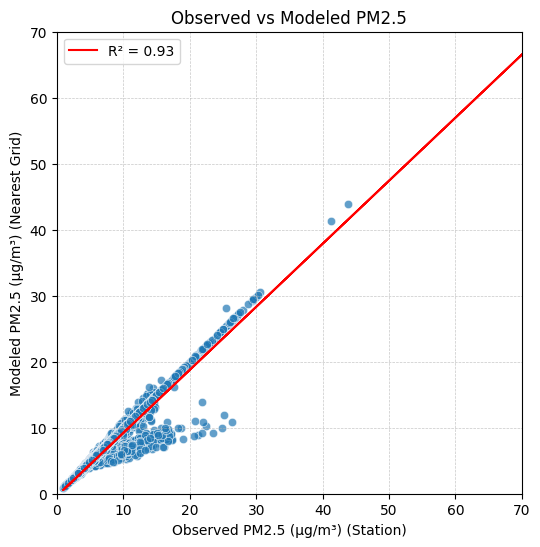

Mean Absolute Error (MAE): 0.88
Root Mean Squared Error (RMSE): 1.78


In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("basePM25nearest_grid.csv")

# Extract observed and modeled PM2.5 values
observed_pm25 = stations["SURF_ug_PM25_rh50"]
modeled_pm25 = stations["nearest_SURF_ug_PM25_rh50"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_pm25, modeled_pm25)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_pm25, y=modeled_pm25, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_pm25, slope * observed_pm25 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed PM2.5 (µg/m³) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled PM2.5 (µg/m³) (Nearest Grid)")
plt.title("Observed vs Modeled PM2.5")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_pm25, modeled_pm25)
rmse = np.sqrt(mean_squared_error(observed_pm25, modeled_pm25))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
